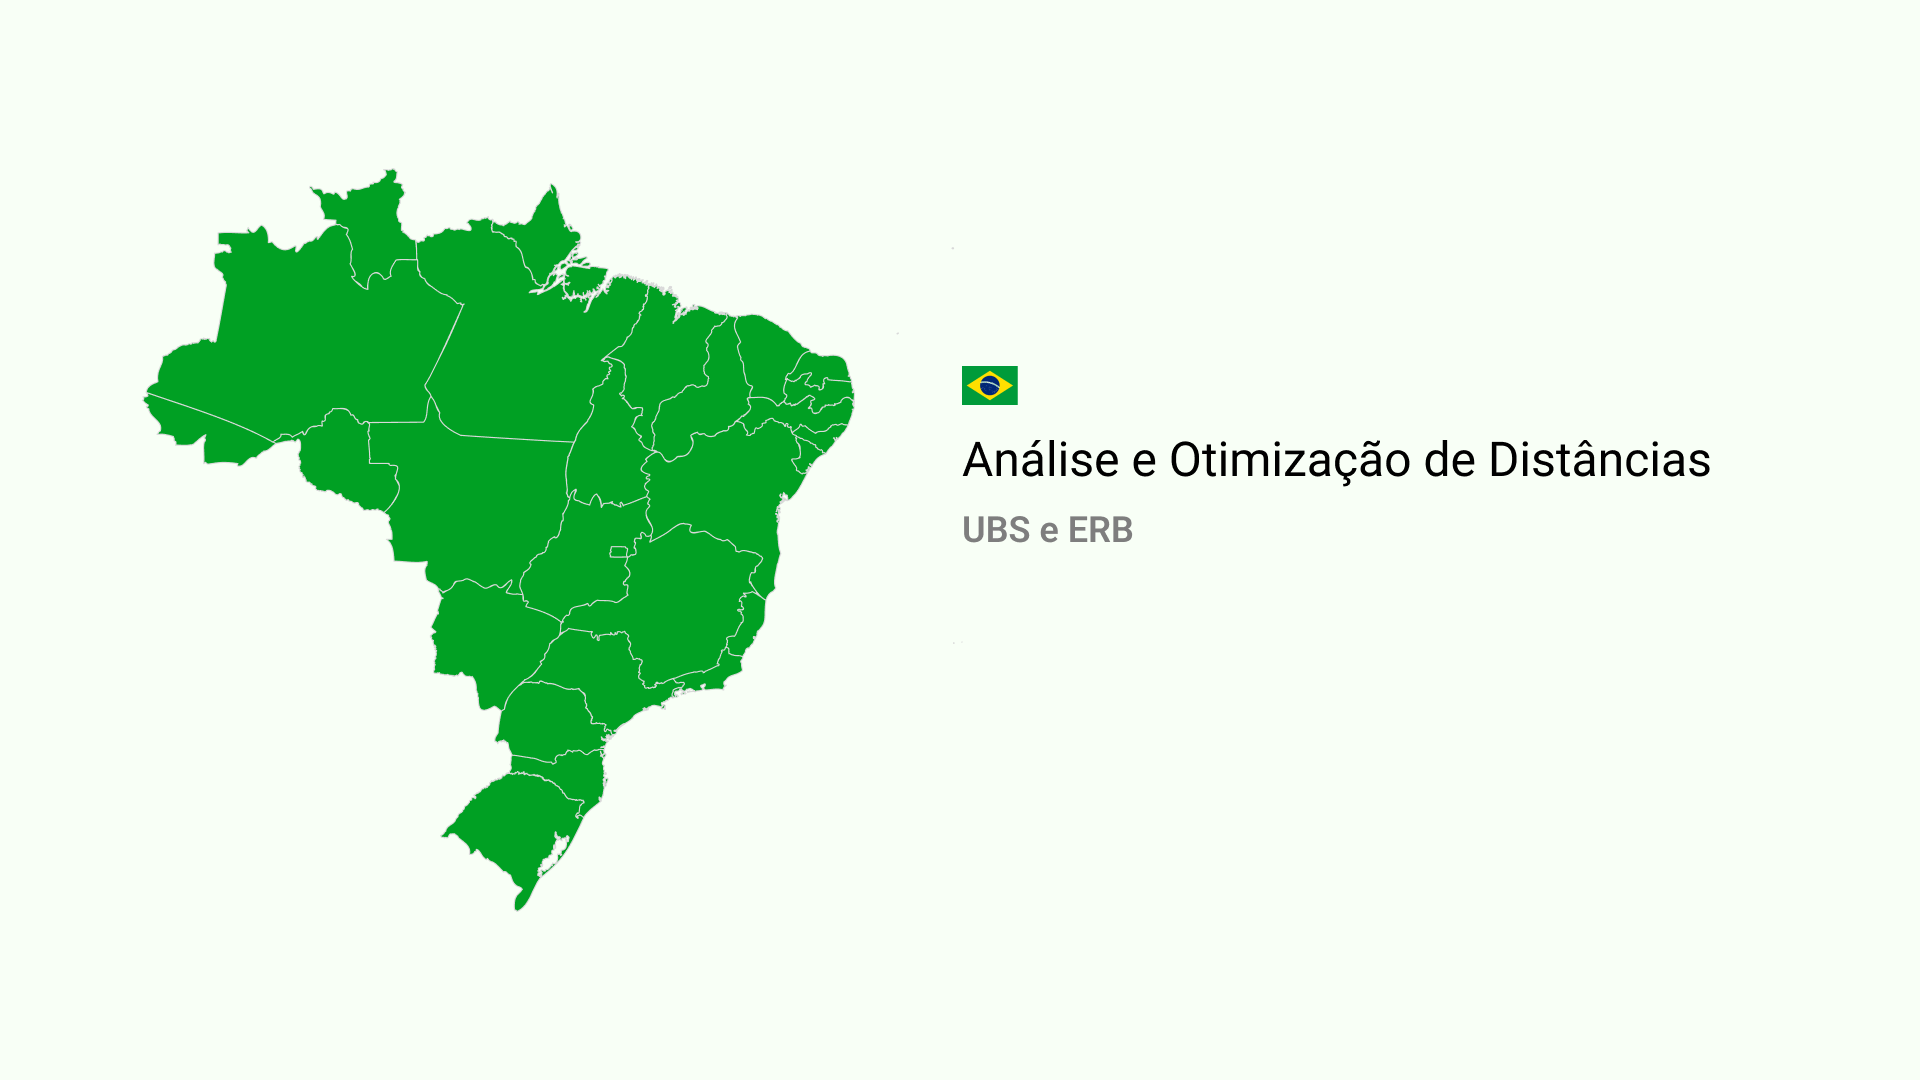

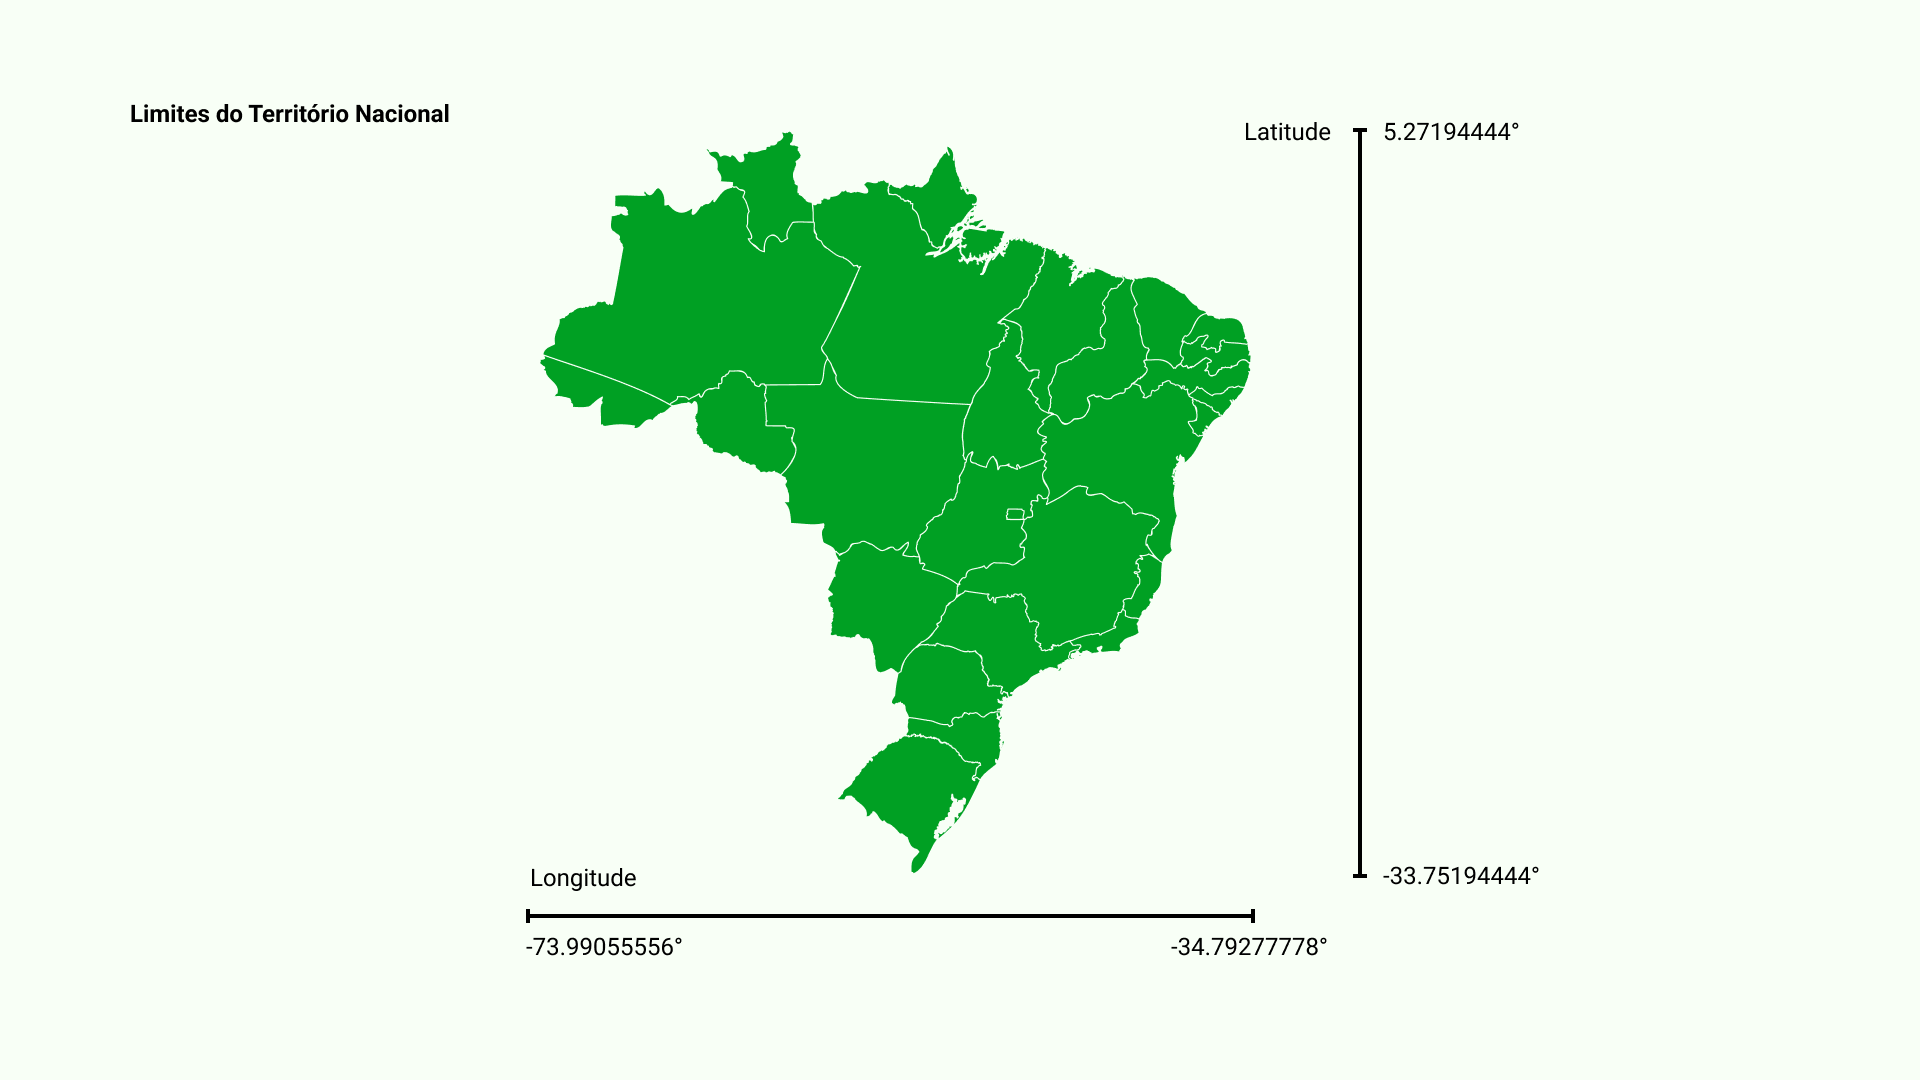

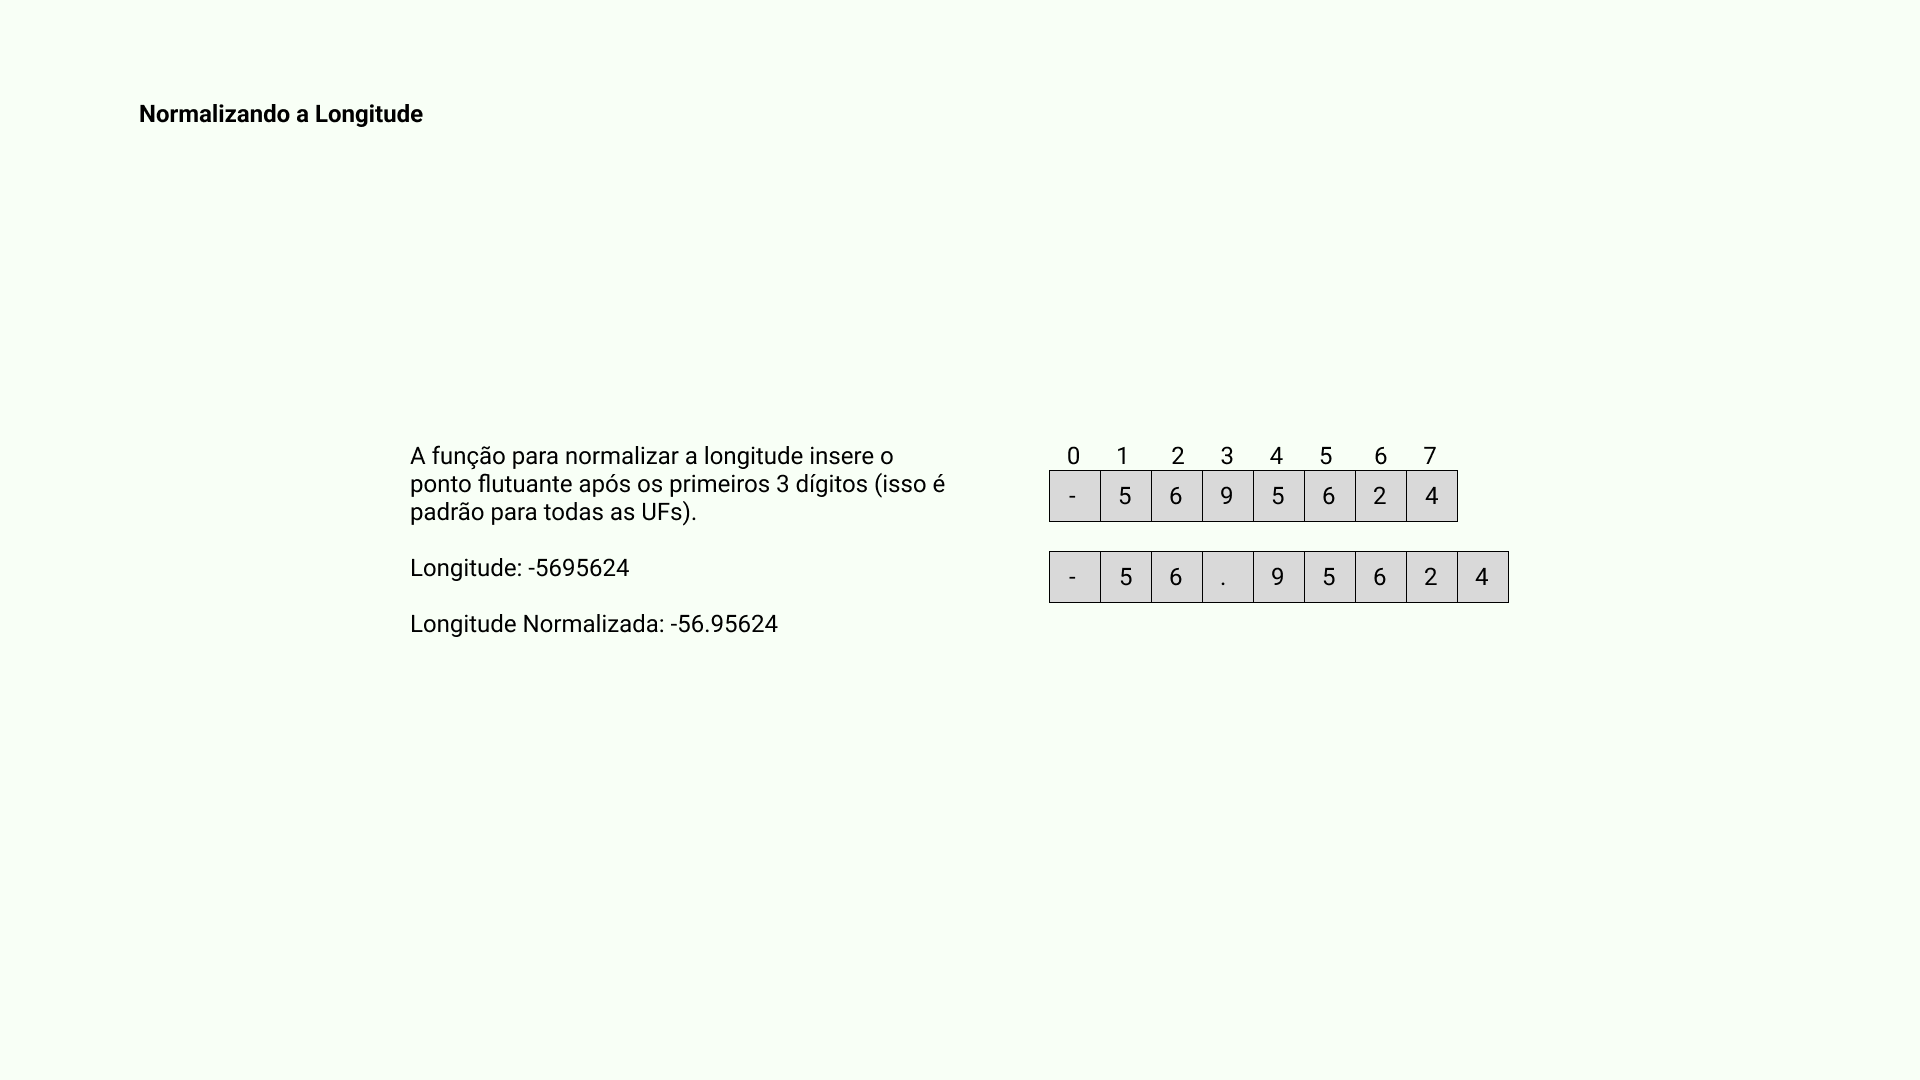

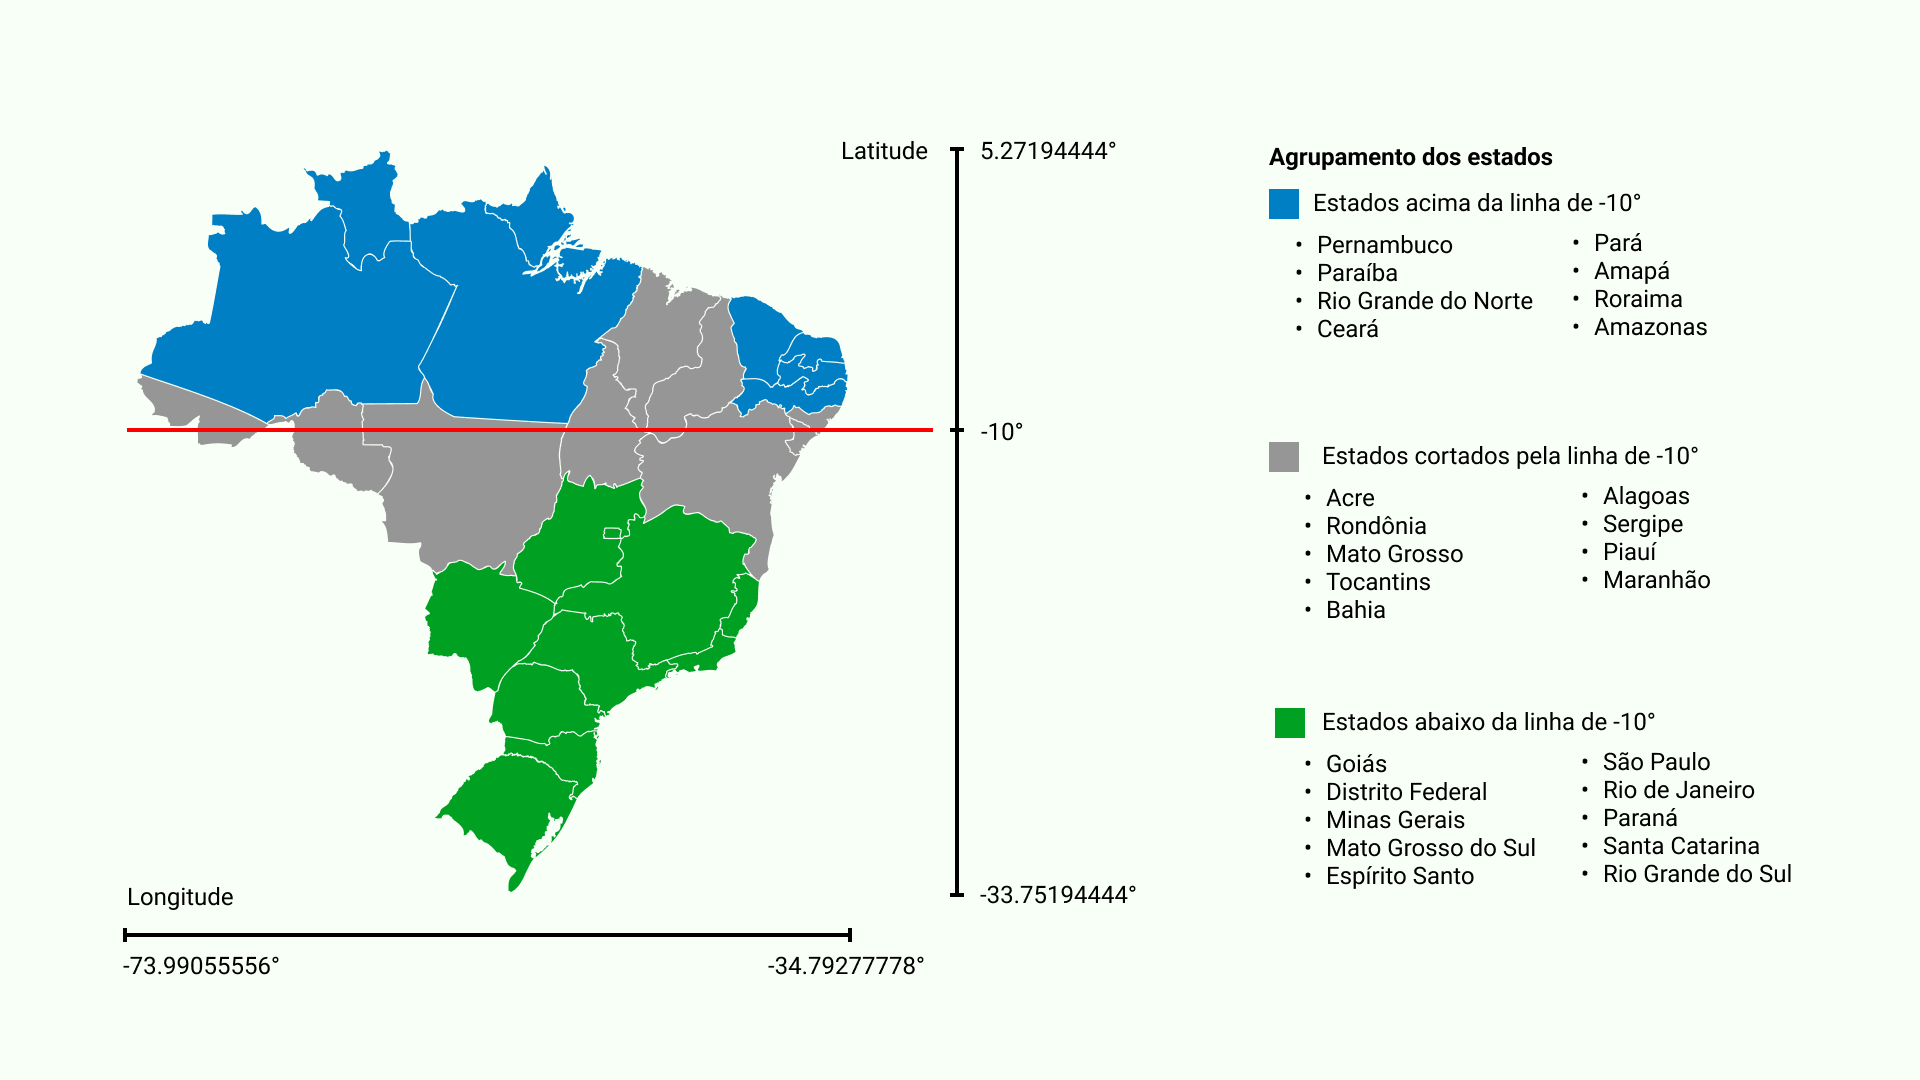

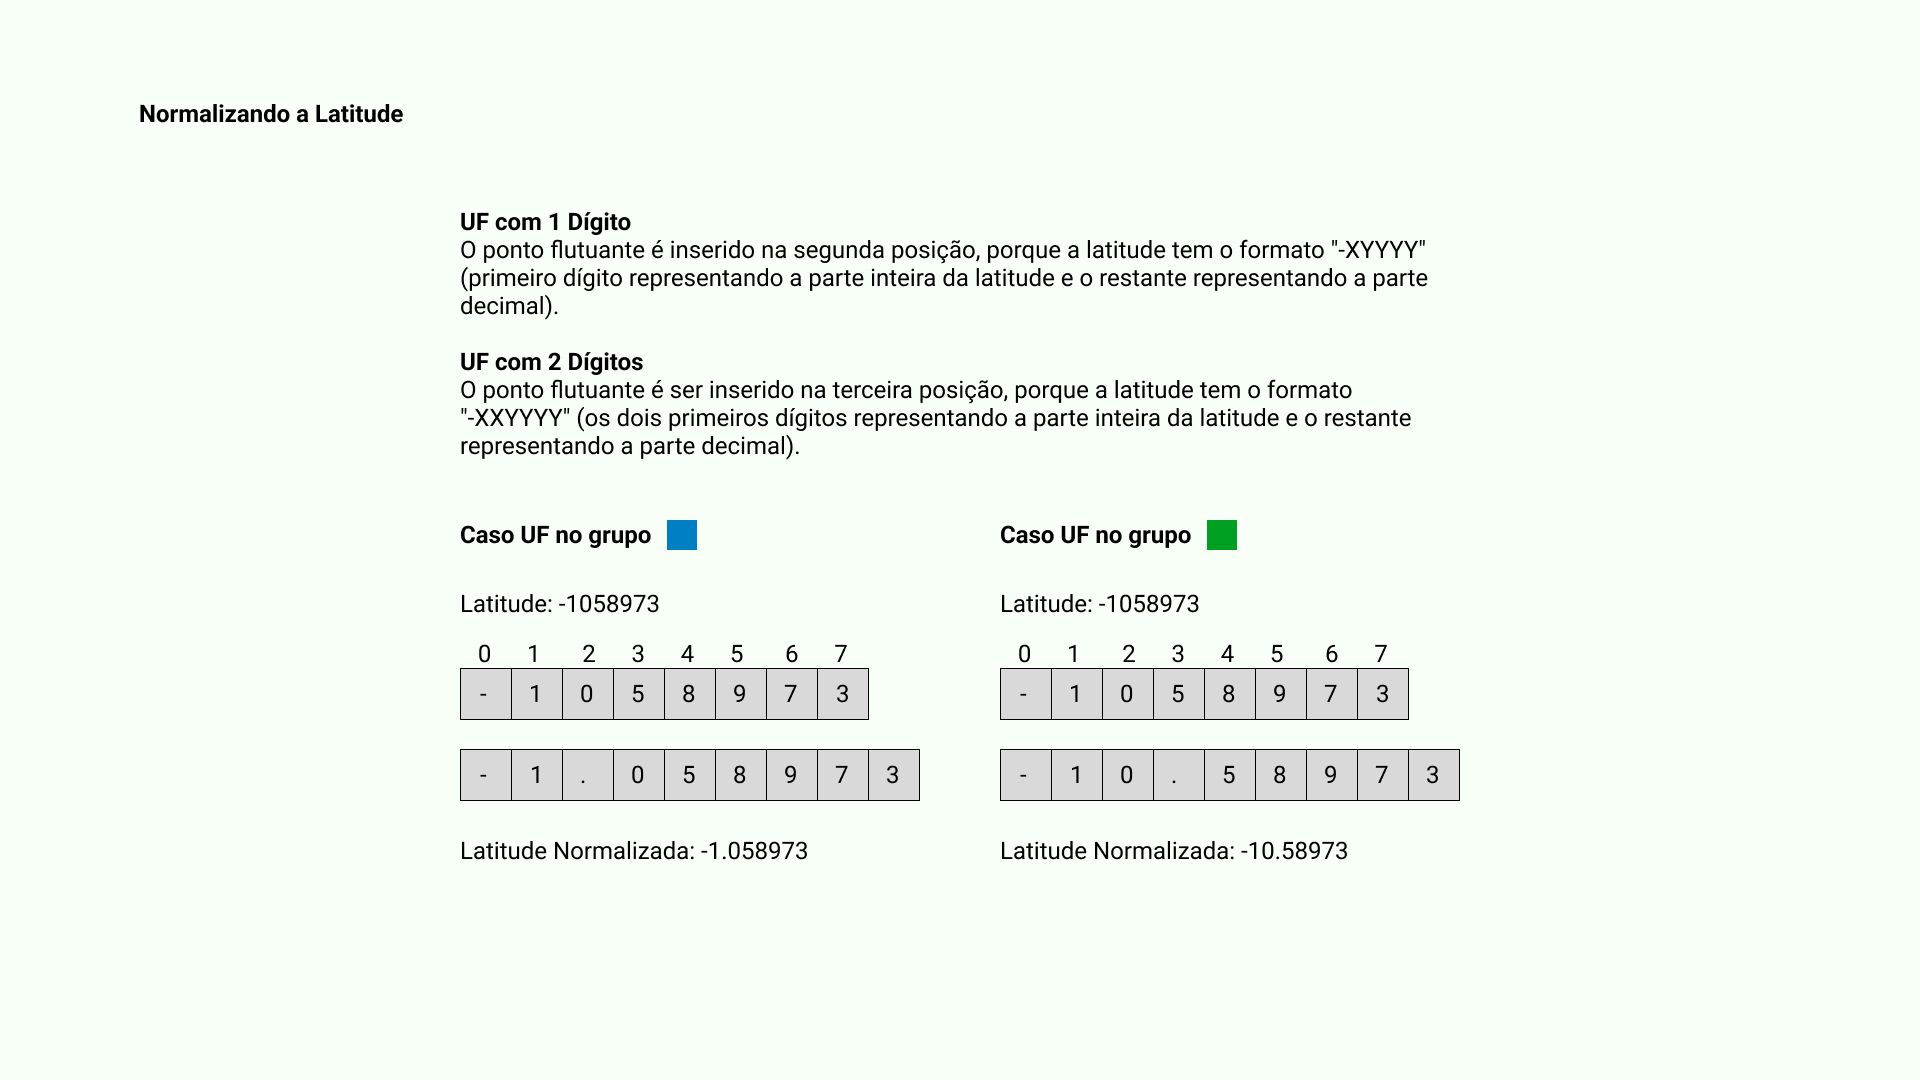

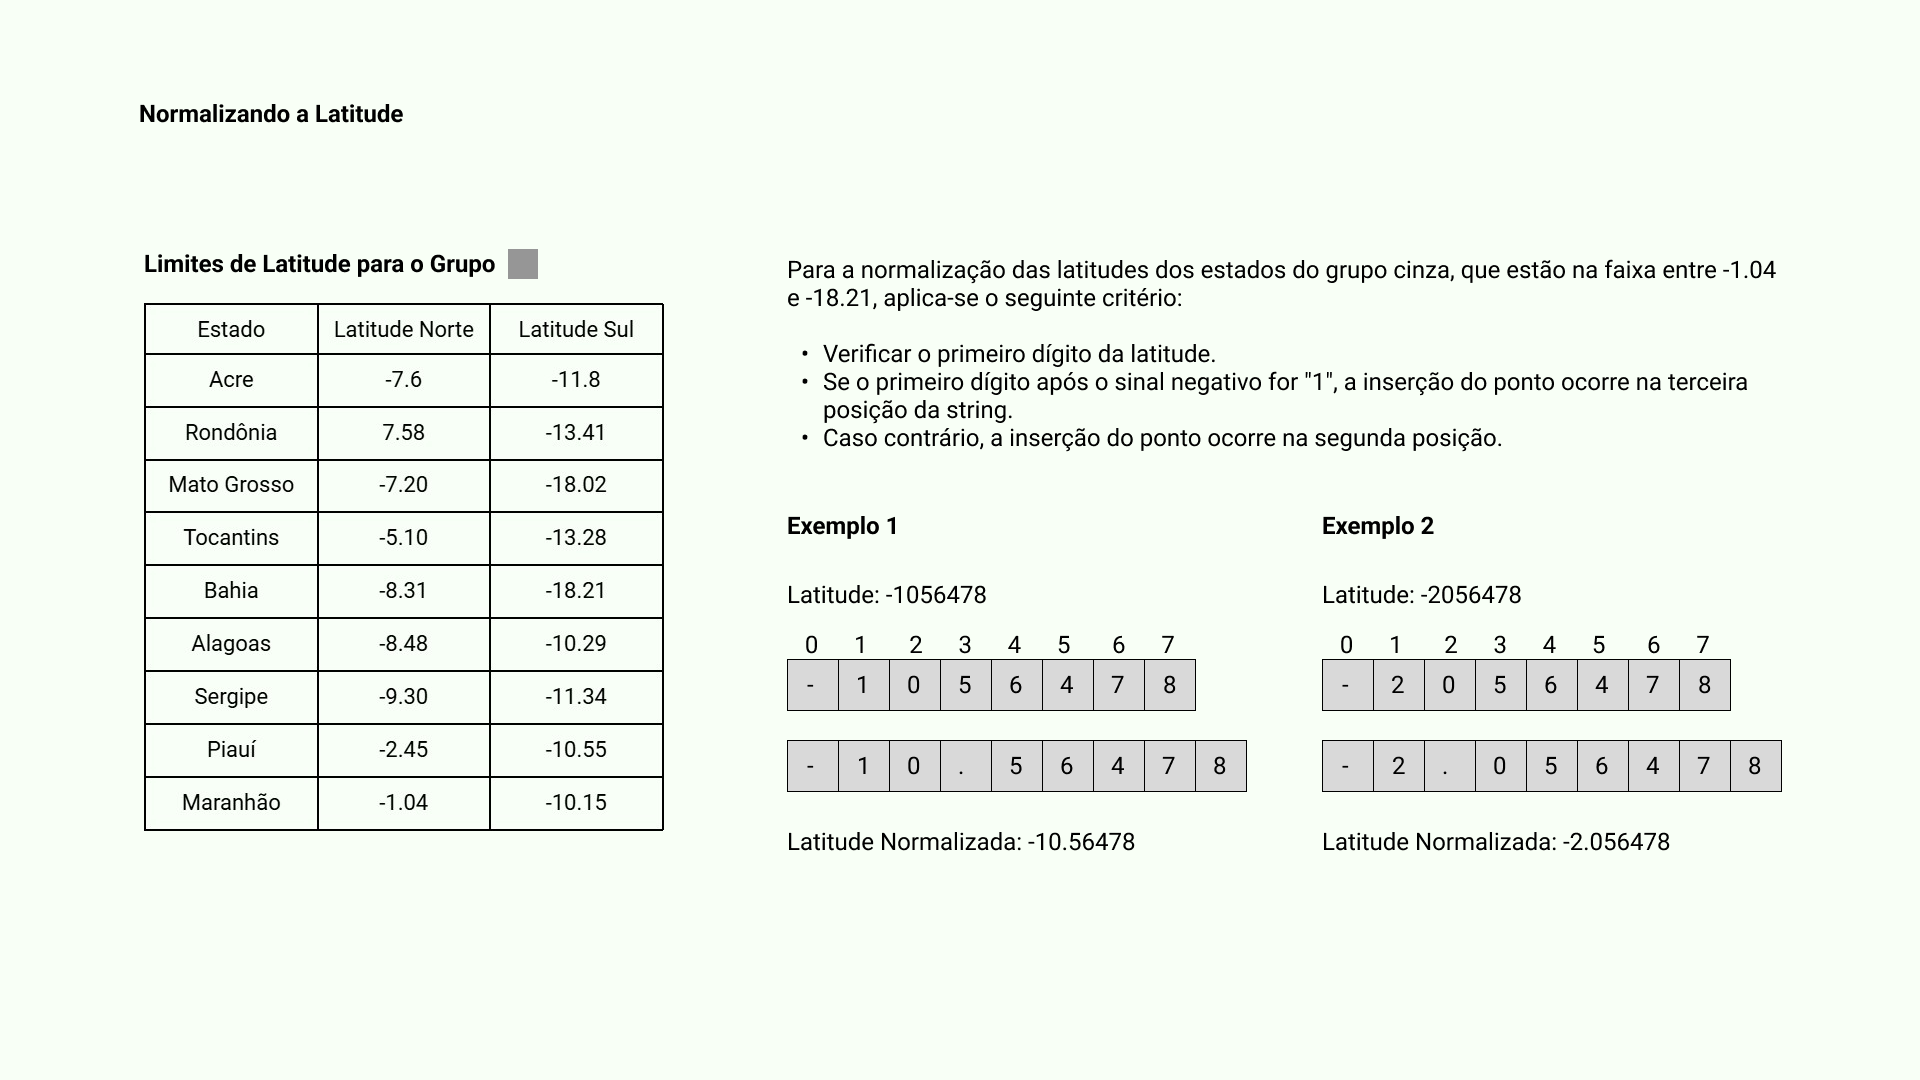

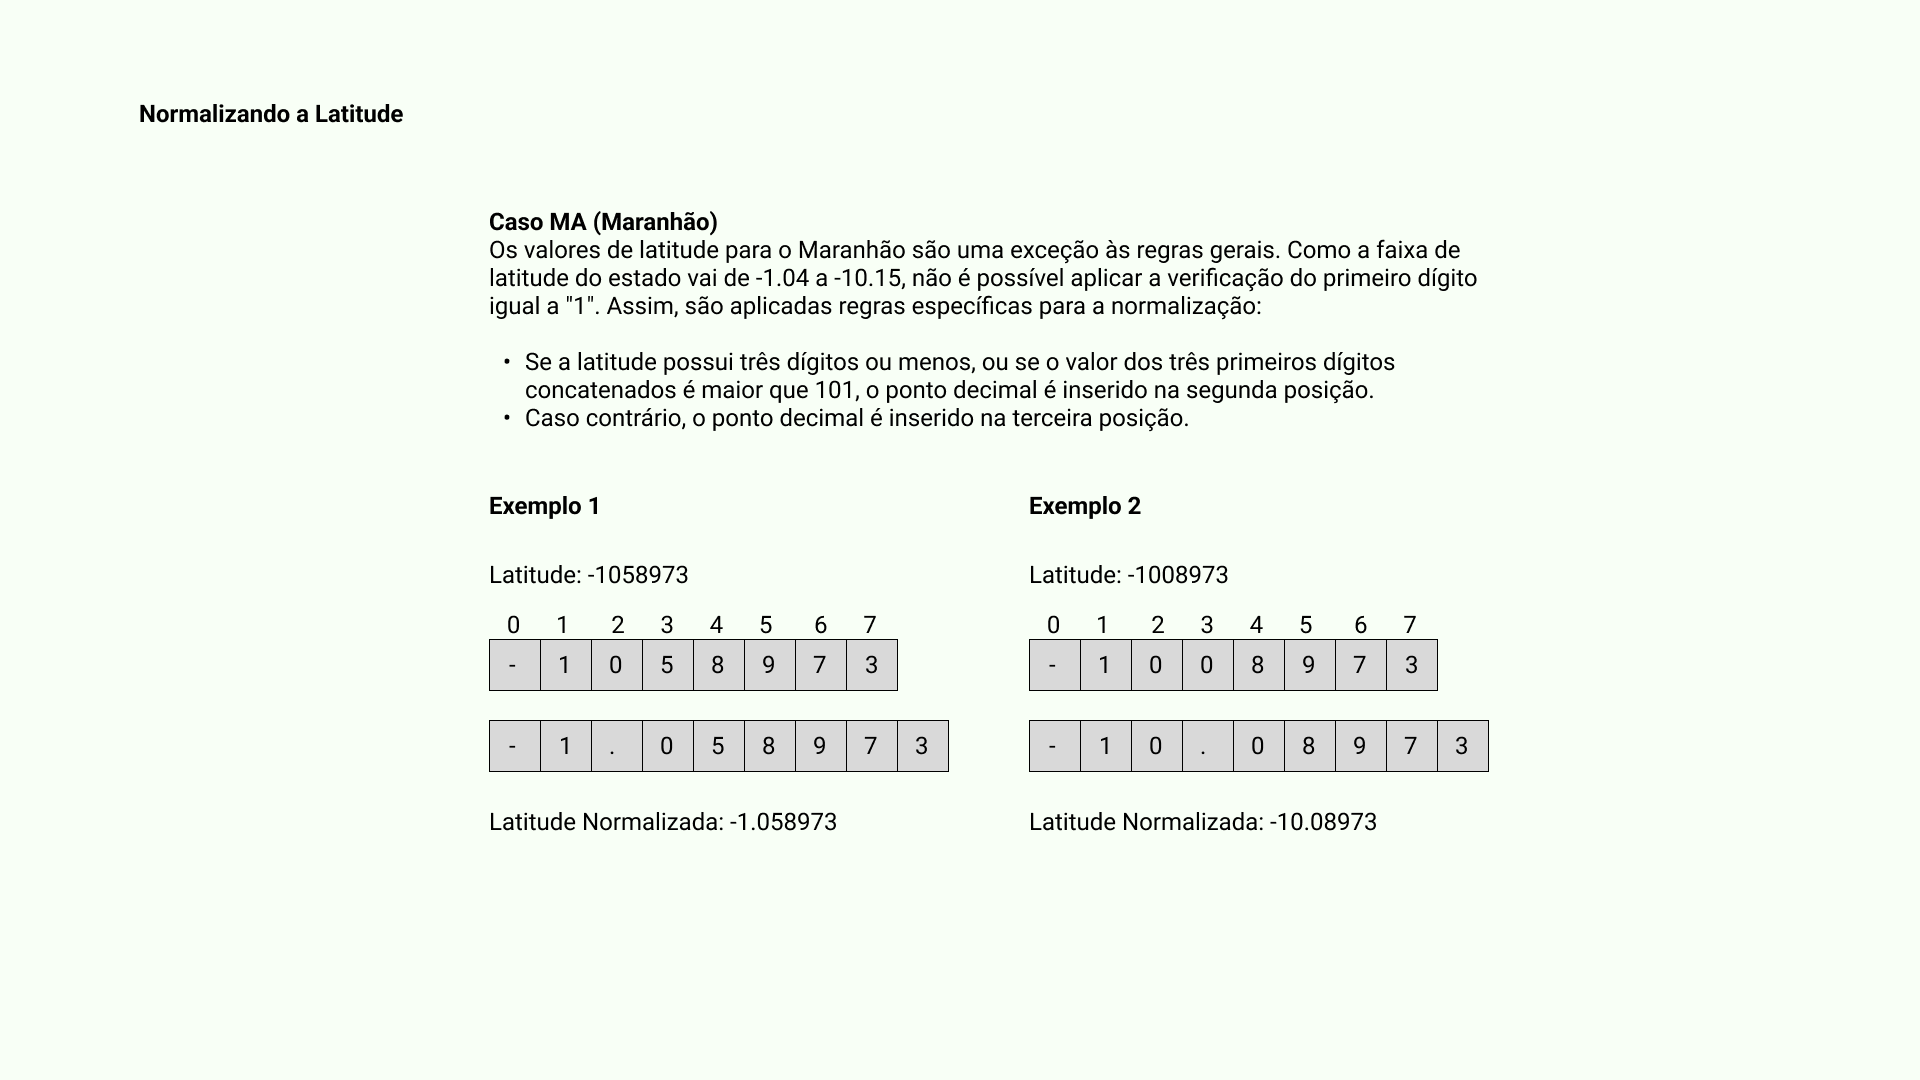

In [ ]:
!pip install folium # Install folium package
!pip install geopy # Install the geopy package
import pandas as pd
import folium
from folium import branca
from geopy.distance import geodesic
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
# The following line was causing issues:
# from concurrent.futures import ThreadPoolExecutor, as_completed
# concurrent.futures is built-in, no need to install
from tqdm import tqdm # This line is redundant, already imported
from folium.plugins import MarkerCluster
from IPython.display import IFrame
import random
from scipy.spatial import KDTree


In [ ]:
# Carregando os dados
# Abertura do arquivo das ERBS com mudança de tipo das colunas para string
erb_from_arquivo = pd.read_csv('/content/Erbs desafio.csv', dtype=str)

# Abertura do arquivo das UBS com mudança de tipo das colunas para string, preservando o 0 a esquerda
ubs_from_arquivo = pd.read_csv('/content/UBS desconectadas desafio.csv', dtype=str)

In [ ]:
ubs_from_arquivo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8825 entries, 0 to 8824
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   UF                    8825 non-null   object
 1   Município             8825 non-null   object
 2   Tipo Unidade          8825 non-null   object
 3   Tipo Estabelecimento  8825 non-null   object
 4   Natureza Jurídica     8825 non-null   object
 5   Status Unidade        8825 non-null   object
 6   Conexão Internet      8825 non-null   object
 7   NU_LATITUDE           8825 non-null   object
 8   NU_LONGITUDE          8825 non-null   object
dtypes: object(9)
memory usage: 620.6+ KB


In [ ]:
# LIMPEZA DE DADOS

# ERB
erb_new = erb_from_arquivo.copy()

erb_new.rename(columns={
    'Número Estação': 'id_erb',
    'UF': 'uf',
    'Município': 'municipio',
    'Faixa Estação': 'faixa_estacao',
    'Geração': 'geracao',
    'Tecnologia': 'tecnologia',
    '(5G) Tipo de Tecnologia': 'tipo_tecnologia',
    'Latitude decimal': 'erb_latitude',
    'Longitude decimal': 'erb_longitude'
}, inplace=True)

erb = erb_new.groupby(['id_erb', 'uf', 'municipio', 'erb_latitude', 'erb_longitude']).agg({
    'faixa_estacao': lambda x: list(set(x)),
    'geracao': lambda x: list(set(x)),
    'tecnologia': lambda x: list(set(x)),
    'tipo_tecnologia': lambda x: list(set([val for val in x if val]))
}).reset_index()

# Remover células com ids duplicados
erb = erb_new.drop_duplicates(subset='id_erb')


# UBS
ubs = ubs_from_arquivo.copy()

ubs.rename(columns={
    'UF': 'uf',
    'Município': 'municipio',
    'NU_LATITUDE': 'ubs_latitude',
    'NU_LONGITUDE': 'ubs_longitude',
    'Tipo Unidade': 'tipo_unidade',
    'Tpo Estabelecimento': 'tipo_estabelecimento',
    'Natureza Jurídica': 'natureza_juridica',
    'Status Unidade': 'status_unidade',
    'Conexão Internet': 'status_internet'
}, inplace=True)

# Adiciona uma nova coluna de IDs únicos para as UBS
ubs['id_ubs'] = (ubs.index + 1).astype(str)

In [ ]:
erb.info()
ubs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102768 entries, 0 to 637589
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id_erb           102767 non-null  object
 1   uf               102768 non-null  object
 2   municipio        102768 non-null  object
 3   faixa_estacao    102768 non-null  object
 4   geracao          102768 non-null  object
 5   tecnologia       102152 non-null  object
 6   tipo_tecnologia  11012 non-null   object
 7   erb_latitude     102768 non-null  object
 8   erb_longitude    102768 non-null  object
dtypes: object(9)
memory usage: 7.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8825 entries, 0 to 8824
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   uf                    8825 non-null   object
 1   municipio             8825 non-null   object
 2   tipo_unidade          8825 non-null  

In [ ]:
# Normalização do dados UBS
# Função para normalizar latitude e longitude

def inserir_ponto(numero_str, posicao):
    return float(numero_str[:posicao] + '.' + numero_str[posicao:])

def normalize_latitude(value, uf):
    numero_str = str(value)
    # Utilização de conjuntos, ver diferença entre arrays
    ufs_one_digit = {'PE', 'PB', 'RN', 'CE', 'PA', 'AP', 'RR', 'AM'}
    ufs_two_digits = {'GO', 'DF', 'MG', 'MS', 'ES', 'SP', 'RJ', 'PR', 'SC', 'RS'}
    ufs_special_case = {'AC', 'RO', 'MT', 'TO', 'BA', 'AL', 'SE', 'PI', 'MA'}

    if value[0] != '-':
        return inserir_ponto(numero_str, 1)

    if uf in ufs_one_digit:
        return inserir_ponto(numero_str, 2)
    elif uf in ufs_two_digits:
        return inserir_ponto(numero_str, 3)
    elif uf in ufs_special_case:
        if uf == 'MA':
            if len(value) <= 3 or int(value[1:4]) > 101:
                return inserir_ponto(numero_str, 2)
            else:
                return inserir_ponto(numero_str, 3)
        return inserir_ponto(numero_str, 3 if value[1] == '1' else 2)

    raise ValueError("UF inválida ou não mapeada.")

def normalize_longitude(value):
    numero_str = str(value)
    return float(numero_str[:3] + '.' + numero_str[3:])

def toString(value):
  return str(value)

In [ ]:
# NORMALIZAÇÃO DE DADOS
# Aplica a normalização de latitude e longitude
ubs['ubs_latitude'] = ubs.apply(lambda row: normalize_latitude(row['ubs_latitude'], row['uf']), axis=1)
ubs['ubs_longitude'] = ubs['ubs_longitude'].apply(normalize_longitude)

In [ ]:
# Converte as colunas de latitude e longitude para float no DataFrame erb
erb['erb_latitude'] = erb['erb_latitude'].astype(float)
erb['erb_longitude'] = erb['erb_longitude'].astype(float)

<ipython-input-58-e132b2743147>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  erb['erb_latitude'] = erb['erb_latitude'].astype(float)
<ipython-input-58-e132b2743147>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  erb['erb_longitude'] = erb['erb_longitude'].astype(float)


In [ ]:
erb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102768 entries, 0 to 637589
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id_erb           102767 non-null  object 
 1   uf               102768 non-null  object 
 2   municipio        102768 non-null  object 
 3   faixa_estacao    102768 non-null  object 
 4   geracao          102768 non-null  object 
 5   tecnologia       102152 non-null  object 
 6   tipo_tecnologia  11012 non-null   object 
 7   erb_latitude     102768 non-null  float64
 8   erb_longitude    102768 non-null  float64
dtypes: float64(2), object(7)
memory usage: 7.8+ MB


In [ ]:
# Clonagem dos DFs para calculo por zonas
# ERB
erb_for_zones = erb.copy()

erb_for_zones.rename(columns={
    'uf': 'erb_uf',
    'municipio': 'erb_municipio',
}, inplace=True)

# Converte as colunas de latitude e longitude para float no DataFrame erb
erb_for_zones.loc[:, 'erb_latitude'] = pd.to_numeric(erb_for_zones['erb_latitude'], errors='coerce')
erb_for_zones.loc[:, 'erb_longitude'] = pd.to_numeric(erb_for_zones['erb_longitude'], errors='coerce')

# UBS
ubs_for_zones = ubs.copy()

ubs_for_zones.rename(columns={
    'uf': 'ubs_uf',
    'municipio': 'ubs_municipio',
}, inplace=True)


In [ ]:
erb_for_zones.info()
ubs_for_zones.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102768 entries, 0 to 637589
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id_erb           102767 non-null  object 
 1   erb_uf           102768 non-null  object 
 2   erb_municipio    102768 non-null  object 
 3   faixa_estacao    102768 non-null  object 
 4   geracao          102768 non-null  object 
 5   tecnologia       102152 non-null  object 
 6   tipo_tecnologia  11012 non-null   object 
 7   erb_latitude     102768 non-null  float64
 8   erb_longitude    102768 non-null  float64
dtypes: float64(2), object(7)
memory usage: 7.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8825 entries, 0 to 8824
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ubs_uf                8825 non-null   object 
 1   ubs_municipio         8825 non-null   object 
 2   tipo_unida

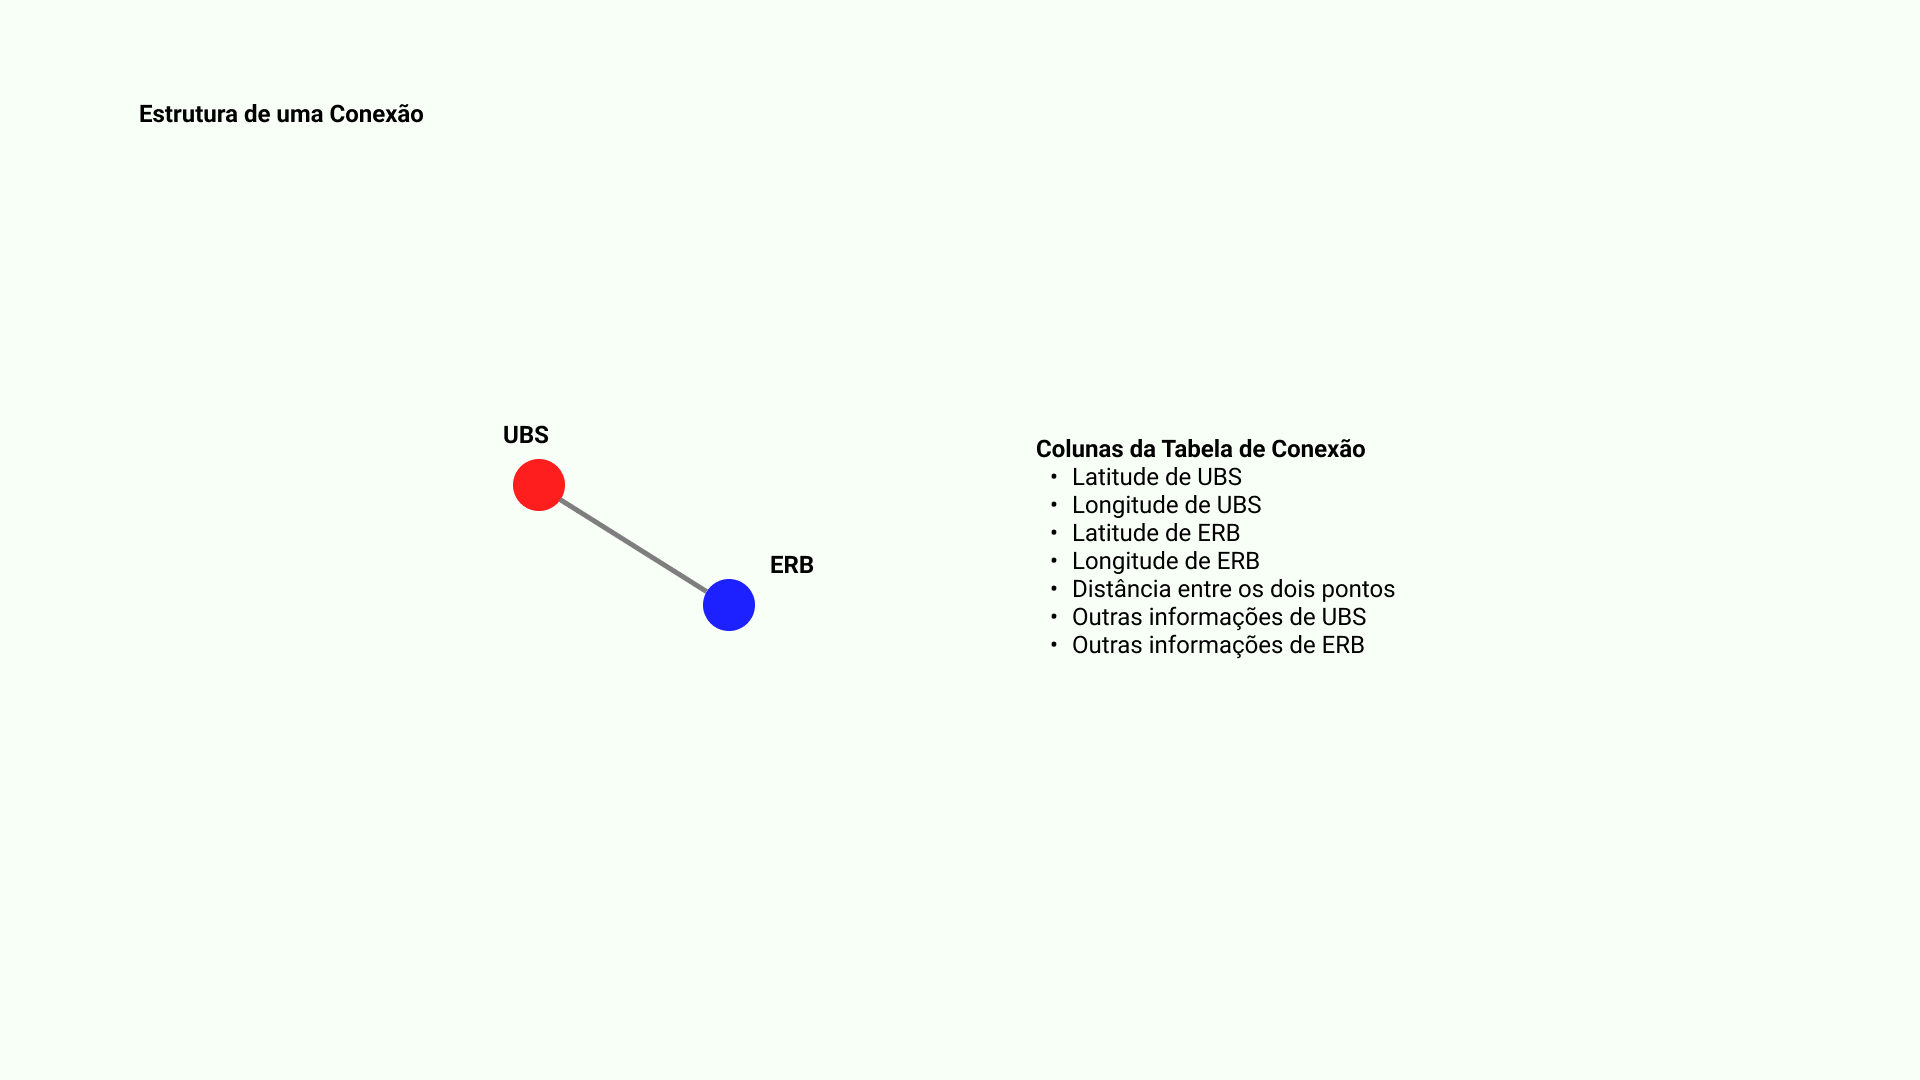

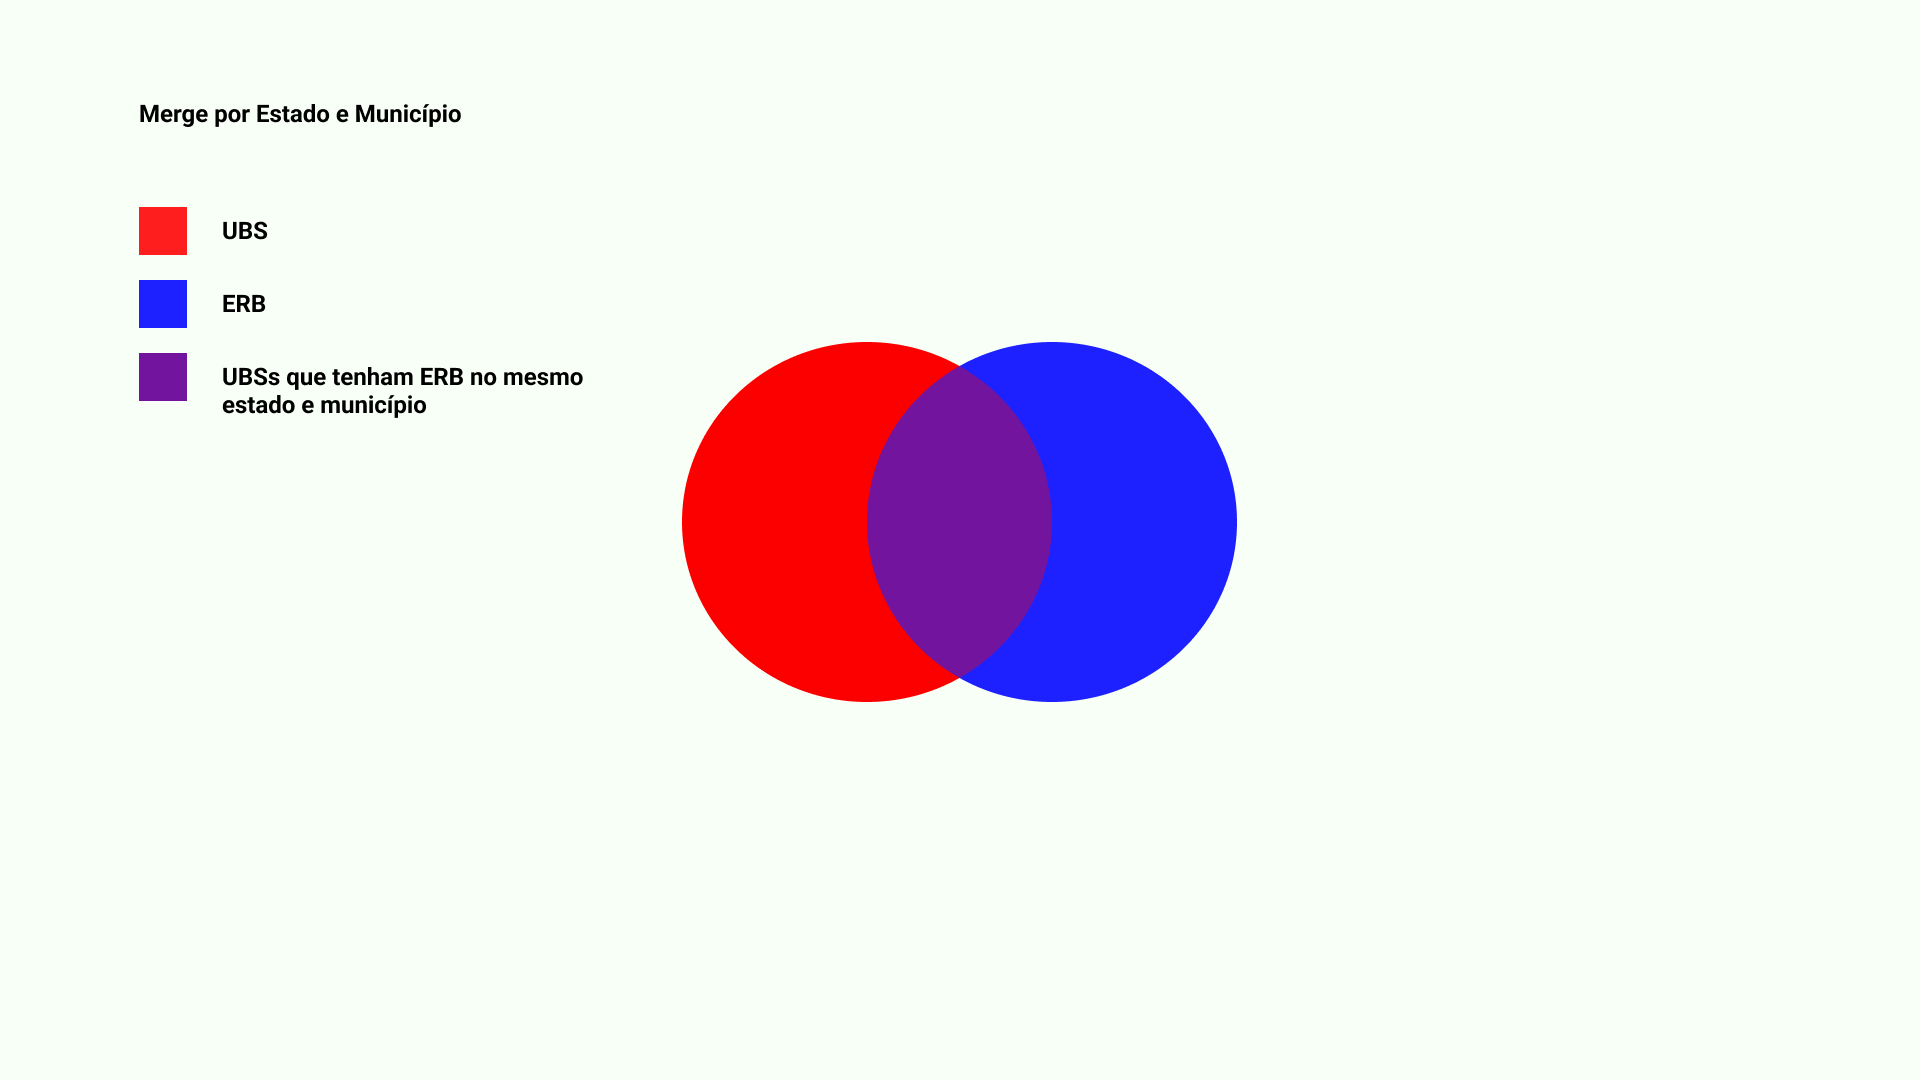

In [ ]:
# Aplica a normalização de municipio
erb.loc[:, 'municipio'] = erb['municipio'].str.strip().str.lower()
ubs.loc[:, 'municipio'] = ubs['municipio'].str.strip().str.lower()

# Realiza o merge entre os DataFrames
conexao = pd.merge(ubs, erb, on=['uf', 'municipio'], how='inner')

In [ ]:
# Realiza o left join entre os DataFrames
conexao_left = pd.merge(ubs, erb, on=['uf', 'municipio'], how='left', indicator=True)

# Filtra as UBS que não possuem correspondência com ERB (indicador 'left_only')
ubs_sem_erb = conexao_left[conexao_left['_merge'] == 'left_only']

In [ ]:
ubs_sem_erb.rename(columns={
    'uf': 'ubs_uf',
    'municipio': 'ubs_municipio',
}, inplace=True)

<ipython-input-64-e137f154dc43>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ubs_sem_erb.rename(columns={


In [ ]:
ubs_sem_erb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3629 entries, 25 to 264649
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ubs_uf                3629 non-null   object  
 1   ubs_municipio         3629 non-null   object  
 2   tipo_unidade          3629 non-null   object  
 3   Tipo Estabelecimento  3629 non-null   object  
 4   natureza_juridica     3629 non-null   object  
 5   status_unidade        3629 non-null   object  
 6   status_internet       3629 non-null   object  
 7   ubs_latitude          3629 non-null   float64 
 8   ubs_longitude         3629 non-null   float64 
 9   id_ubs                3629 non-null   object  
 10  id_erb                0 non-null      object  
 11  faixa_estacao         0 non-null      object  
 12  geracao               0 non-null      object  
 13  tecnologia            0 non-null      object  
 14  tipo_tecnologia       0 non-null      object  
 15  erb_la

In [ ]:
# Seleciona apenas as colunas relacionadas à UBS
ubs_only = ubs_sem_erb[['ubs_uf', 'ubs_municipio', 'tipo_unidade',
                          'natureza_juridica', 'status_unidade', 'status_internet',
                          'ubs_latitude', 'ubs_longitude', 'id_ubs', '_merge']]

# Remove a coluna '_merge'
ubs_only = ubs_only.drop(columns=['_merge'])

In [ ]:
ubs_only.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3629 entries, 25 to 264649
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ubs_uf             3629 non-null   object 
 1   ubs_municipio      3629 non-null   object 
 2   tipo_unidade       3629 non-null   object 
 3   natureza_juridica  3629 non-null   object 
 4   status_unidade     3629 non-null   object 
 5   status_internet    3629 non-null   object 
 6   ubs_latitude       3629 non-null   float64
 7   ubs_longitude      3629 non-null   float64
 8   id_ubs             3629 non-null   object 
dtypes: float64(2), object(7)
memory usage: 283.5+ KB


In [ ]:
# Definindo os limites do território nacional
latitude_min, latitude_max = -33.75194444, 5.10250000
longitude_min, longitude_max = -73.99055556, -34.79277778

# Gerar uma lista de valores de latitude e longitude com passos de 2.7
latitudes = np.arange(latitude_min, latitude_max, 2.7)
longitudes = np.arange(longitude_min, longitude_max, 2.7)

# Criando uma lista para armazenar as zonas
zonas = []

# Gerando as zonas com IDs únicos
id_zona = 1
for lat_min in latitudes:
    for lon_min in longitudes:
        zonas.append({
            'id': id_zona,
            'latitude_min': lat_min,
            'latitude_max': lat_min + 2.7,
            'longitude_min': lon_min,
            'longitude_max': lon_min + 2.7
        })
        id_zona += 1

print(zonas[0])

df_zonas = pd.DataFrame(zonas)

df_zonas.head()
df_zonas.to_csv('zonas_territorio_nacional.csv', index=False)

print("DataFrame salvo como 'zonas_territorio_nacional.csv'")
df_zonas.head()


{'id': 1, 'latitude_min': -33.75194444, 'latitude_max': -31.051944440000003, 'longitude_min': -73.99055556, 'longitude_max': -71.29055556}
DataFrame salvo como 'zonas_territorio_nacional.csv'


,id,latitude_min,latitude_max,longitude_min,longitude_max
0,1,-33.751944,-31.051944,-73.990556,-71.290556
1,2,-33.751944,-31.051944,-71.290556,-68.590556
2,3,-33.751944,-31.051944,-68.590556,-65.890556
3,4,-33.751944,-31.051944,-65.890556,-63.190556
4,5,-33.751944,-31.051944,-63.190556,-60.490556


In [ ]:
df_zonas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             225 non-null    int64  
 1   latitude_min   225 non-null    float64
 2   latitude_max   225 non-null    float64
 3   longitude_min  225 non-null    float64
 4   longitude_max  225 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 8.9 KB


In [ ]:
# Encontrar zona mais príxima para uma coordenada
# A função para busca de vizinhos próximos aumeta a precisão, porém
# também aumenta a quantidade de registros finais, aumentando a necessidade computacional
# para o cáclulo de distâncias.
# Para o ajuste fino, o ideal é um equilibrio entre o tamanho das zonas e a quantidade
# de vizinhos retornada, definido no valor "k" da função encontrar_zona_mais_proxima

# Caso a função encontrar_zona_mais_proxima seja utilizada, será necessário
# explodir os registros do data frame, e só depois poderá ser feito o cálculo de distâncias

# def encontrar_zona_mais_proxima(lat, lon, kd_tree, df_zonas):
#     # Procurar a zona mais próxima usando KDTree
#     _, idx = kd_tree.query([lat, lon],k=2)
#     return df_zonas.iloc[idx]['id'].values.tolist()

def encontrar_zona_mais_proxima(lat, lon, kd_tree, df_zonas):
    # Procurar a zona mais próxima usando KDTree
    _, idx = kd_tree.query([lat, lon],k=1)
    return df_zonas.iloc[idx]['id']

# Média das latitudes e longitudes para representar o centro de cada zona
# df_zonas['latitude_centro'] = (df_zonas['latitude_min'] + df_zonas['latitude_max']) / 2
# df_zonas['longitude_centro'] = (df_zonas['longitude_min'] + df_zonas['longitude_max']) / 2

df_zonas['latitude_centro'] = df_zonas['latitude_min'] + (df_zonas['latitude_max'] - df_zonas['latitude_min']) / 2
df_zonas['longitude_centro'] = df_zonas['longitude_min'] + (df_zonas['longitude_max'] - df_zonas['longitude_min']) / 2

# Construir uma KDTree com as coordenadas centrais das zonas
zonas_coords = df_zonas[['latitude_centro', 'longitude_centro']].values

kd_tree = KDTree(zonas_coords)

In [ ]:
# Encontrar zonas próximas de cada UBS
ubs_coords = ubs_only[['ubs_latitude', 'ubs_longitude']].values
ubs_only['id_zona'] = [encontrar_zona_mais_proxima(lat, lon, kd_tree, df_zonas) for lat, lon in ubs_coords]

# Encontrar zonas próximas de cada ERB
erb_coords = erb_for_zones[['erb_latitude', 'erb_longitude']].values
erb_for_zones['id_zona'] = [encontrar_zona_mais_proxima(lat, lon, kd_tree, df_zonas) for lat, lon in erb_coords]

In [ ]:
erb_for_zones.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102768 entries, 0 to 637589
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id_erb           102767 non-null  object 
 1   erb_uf           102768 non-null  object 
 2   erb_municipio    102768 non-null  object 
 3   faixa_estacao    102768 non-null  object 
 4   geracao          102768 non-null  object 
 5   tecnologia       102152 non-null  object 
 6   tipo_tecnologia  11012 non-null   object 
 7   erb_latitude     102768 non-null  float64
 8   erb_longitude    102768 non-null  float64
 9   id_zona          102768 non-null  float64
dtypes: float64(3), object(7)
memory usage: 8.6+ MB


In [ ]:
erb_for_zones.head()

,id_erb,erb_uf,erb_municipio,faixa_estacao,geracao,tecnologia,tipo_tecnologia,erb_latitude,erb_longitude,id_zona
0,1016092277.0,DF,Brasília,2100,3G,WCDMA,NaN,-15.79608,-47.88889,100.0
4,1016084142.0,RJ,São Gonçalo,700,4G,LTE,NaN,-22.80758,-42.97929,72.0
6,1016084134.0,RJ,Nova Iguaçu,700,4G,LTE,NaN,-22.72491,-43.45721,72.0
8,1016084126.0,RJ,Nova Iguaçu,700,4G,LTE,NaN,-22.77304,-43.52428,72.0
10,1016084118.0,RJ,Nova Iguaçu,700,4G,LTE,NaN,-22.75103,-43.50056,72.0


In [ ]:
# Explodir a coluna 'id_zona' da UBS para ter uma linha por zona
# ubs_exploded = ubs_only.explode('id_zona').reset_index(drop=True)

# # Explodir a coluna 'id_zona' da ERB para ter uma linha por zona
# erb_exploded = erb_for_zones.explode('id_zona').reset_index(drop=True)

In [ ]:
# ubs_exploded.info()

In [ ]:
# erb_exploded.head()

In [ ]:
# Associação entre uma UBS e cada ERB na mesma zona
# conexao_zone = pd.merge(ubs_exploded, erb_exploded, on='id_zona', how='inner', indicator=True) # Adding indicator=True



In [ ]:
# Associação entre uma UBS e cada ERB na mesma zona
conexao_zone = pd.merge(ubs_only, erb_for_zones, on='id_zona', how='inner', indicator=True) # Adding indicator=True

In [ ]:
conexao_zone.head()

,ubs_uf,ubs_municipio,tipo_unidade,natureza_juridica,status_unidade,status_internet,ubs_latitude,ubs_longitude,id_ubs,id_zona,id_erb,erb_uf,erb_municipio,faixa_estacao,geracao,tecnologia,tipo_tecnologia,erb_latitude,erb_longitude,_merge
0,AC,jordao,2,MUNICIPIO,Habilitada,Não Conectada,-9.233604,-71.650353,2,136.0,1015757518.0,AC,Rodrigues Alves,850,2G,GSM,NaN,-7.72566,-72.73823,both
1,AC,jordao,2,MUNICIPIO,Habilitada,Não Conectada,-9.233604,-71.650353,2,136.0,1015714371.0,AC,Cruzeiro do Sul,2100,3G,WCDMA,NaN,-7.61632,-72.67191,both
2,AC,jordao,2,MUNICIPIO,Habilitada,Não Conectada,-9.233604,-71.650353,2,136.0,1015439621.0,AC,Cruzeiro do Sul,2100,3G,WCDMA,NaN,-7.62125,-72.66994,both
3,AC,jordao,2,MUNICIPIO,Habilitada,Não Conectada,-9.233604,-71.650353,2,136.0,1015417172.0,AM,Ipixuna,850,2G,GSM,NaN,-6.97916,-71.47298,both
4,AC,jordao,2,MUNICIPIO,Habilitada,Não Conectada,-9.233604,-71.650353,2,136.0,1014817339.0,AC,Cruzeiro do Sul,900,2G,GSM,NaN,-7.63046,-72.66910,both


In [ ]:
#conexao_zone = conexao_zone[conexao_zone['ubs_uf'] == conexao_zone['erb_uf']]

In [ ]:
conexao_zone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7868504 entries, 0 to 7868503
Data columns (total 20 columns):
 #   Column             Dtype   
---  ------             -----   
 0   ubs_uf             object  
 1   ubs_municipio      object  
 2   tipo_unidade       object  
 3   natureza_juridica  object  
 4   status_unidade     object  
 5   status_internet    object  
 6   ubs_latitude       float64 
 7   ubs_longitude      float64 
 8   id_ubs             object  
 9   id_zona            float64 
 10  id_erb             object  
 11  erb_uf             object  
 12  erb_municipio      object  
 13  faixa_estacao      object  
 14  geracao            object  
 15  tecnologia         object  
 16  tipo_tecnologia    object  
 17  erb_latitude       float64 
 18  erb_longitude      float64 
 19  _merge             category
dtypes: category(1), float64(5), object(14)
memory usage: 1.1+ GB


In [ ]:
# Filtrando registros duplicados, mantendo a primeira ocorrência
# ubs_df = df_filtrado[~df_filtrado[['id_ubs']].duplicated(keep='first')]

In [ ]:
# Função de cálculo da distância
def calcular_distancia(row):
    lat1, lon1 = row['ubs_latitude'], row['ubs_longitude']
    lat2, lon2 = row['erb_latitude'], row['erb_longitude']
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Fórmula Haversine
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    R = 6371.0  # Raio da Terra em km
    return R * c

In [ ]:
# Calcular e inserir distancia para conexao por uf e municipio
# Limitar o número de núcleos e adicionar a barra de progresso
conexao['distancia_km'] = Parallel(n_jobs=8)(delayed(calcular_distancia)(row) for _, row in tqdm(conexao.iterrows(), total=conexao.shape[0]))

100%|██████████| 261041/261041 [00:40<00:00, 6370.08it/s]


In [ ]:
# Calcular e inserir distancia para conexao por zona
conexao_zone['distancia_km'] = Parallel(n_jobs=8)(delayed(calcular_distancia)(row) for _, row in tqdm(conexao_zone.iterrows(), total=conexao_zone.shape[0]))

100%|██████████| 7868504/7868504 [20:32<00:00, 6384.62it/s]


In [ ]:
conexao_zone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7868504 entries, 0 to 7868503
Data columns (total 21 columns):
 #   Column             Dtype   
---  ------             -----   
 0   ubs_uf             object  
 1   ubs_municipio      object  
 2   tipo_unidade       object  
 3   natureza_juridica  object  
 4   status_unidade     object  
 5   status_internet    object  
 6   ubs_latitude       float64 
 7   ubs_longitude      float64 
 8   id_ubs             object  
 9   id_zona            float64 
 10  id_erb             object  
 11  erb_uf             object  
 12  erb_municipio      object  
 13  faixa_estacao      object  
 14  geracao            object  
 15  tecnologia         object  
 16  tipo_tecnologia    object  
 17  erb_latitude       float64 
 18  erb_longitude      float64 
 19  _merge             category
 20  distancia_km       float64 
dtypes: category(1), float64(6), object(14)
memory usage: 1.2+ GB


In [ ]:
# Conversao para numeric
# conexao['ubs_latitude'] = pd.to_numeric(conexao['ubs_latitude'], errors='coerce')
# conexao['ubs_longitude'] = pd.to_numeric(conexao['ubs_longitude'], errors='coerce')
# conexao['erb_latitude'] = pd.to_numeric(conexao['erb_latitude'], errors='coerce')
# conexao['erb_longitude'] = pd.to_numeric(conexao['erb_longitude'], errors='coerce')

In [ ]:
# Remover células em que a distância seja maior que 10km (otimização do mapa)
# conexao.drop(conexao[conexao['distancia_km'] > 100].index, inplace=True)

# conexao.head()

In [ ]:
conexao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261041 entries, 0 to 261040
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   uf                    261041 non-null  object 
 1   municipio             261041 non-null  object 
 2   tipo_unidade          261041 non-null  object 
 3   Tipo Estabelecimento  261041 non-null  object 
 4   natureza_juridica     261041 non-null  object 
 5   status_unidade        261041 non-null  object 
 6   status_internet       261041 non-null  object 
 7   ubs_latitude          261041 non-null  float64
 8   ubs_longitude         261041 non-null  float64
 9   id_ubs                261041 non-null  object 
 10  id_erb                261041 non-null  object 
 11  faixa_estacao         261041 non-null  object 
 12  geracao               261041 non-null  object 
 13  tecnologia            258206 non-null  object 
 14  tipo_tecnologia       46189 non-null   object 
 15  

In [ ]:
# Tabela de UBS
ubs_df = conexao[[
    'id_ubs',
    'ubs_latitude',
    'ubs_longitude',
    'uf',
    'municipio',
    'tipo_unidade',
    'natureza_juridica',
    'status_unidade',
    'status_internet'
    ]]

# Filtrando registros duplicados, mantendo a primeira ocorrência
ubs_df = ubs_df[~ubs_df[['id_ubs']].duplicated(keep='first')]

# Tabela de UBS por zona
ubs_zone = conexao_zone[[
    'id_ubs',
    'ubs_latitude',
    'ubs_longitude',
    'ubs_uf',
    'ubs_municipio',
    'tipo_unidade',
    'natureza_juridica',
    'status_unidade',
    'status_internet'
    ]]

# Filtrando registros duplicados, mantendo a primeira ocorrência
ubs_zone = ubs_zone[~ubs_zone[['id_ubs']].duplicated(keep='first')]

In [ ]:
ubs_zone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3629 entries, 0 to 7867957
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_ubs             3629 non-null   object 
 1   ubs_latitude       3629 non-null   float64
 2   ubs_longitude      3629 non-null   float64
 3   ubs_uf             3629 non-null   object 
 4   ubs_municipio      3629 non-null   object 
 5   tipo_unidade       3629 non-null   object 
 6   natureza_juridica  3629 non-null   object 
 7   status_unidade     3629 non-null   object 
 8   status_internet    3629 non-null   object 
dtypes: float64(2), object(7)
memory usage: 283.5+ KB


In [ ]:
# Tabela de ERB
erb_df = conexao[[
    'id_erb',
    'erb_latitude',
    'erb_longitude',
    'uf',
    'municipio',
    'faixa_estacao',
    'geracao',
    'tecnologia',
    'tipo_tecnologia'
]].drop_duplicates(subset=['id_erb', 'erb_latitude', 'erb_longitude'])  # Specify columns without lists


# Tabela de ERB por zona
#filtro = conexao_zone.loc[conexao_zone.groupby('id_ubs')['distancia_km'].idxmin()]
erb_zone = conexao_zone[[
    'id_erb',
    'erb_latitude',
    'erb_longitude',
    'erb_uf',
    'erb_municipio',
    'faixa_estacao',
    'geracao',
    'tecnologia',
    'tipo_tecnologia'
]].drop_duplicates(subset=['id_erb', 'erb_latitude', 'erb_longitude'])  # Specify columns without lists

In [ ]:
erb_zone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102495 entries, 0 to 7861295
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id_erb           102494 non-null  object 
 1   erb_latitude     102495 non-null  float64
 2   erb_longitude    102495 non-null  float64
 3   erb_uf           102495 non-null  object 
 4   erb_municipio    102495 non-null  object 
 5   faixa_estacao    102495 non-null  object 
 6   geracao          102495 non-null  object 
 7   tecnologia       101880 non-null  object 
 8   tipo_tecnologia  10968 non-null   object 
dtypes: float64(2), object(7)
memory usage: 7.8+ MB


In [ ]:
# Contar as ocorrências de cada id_erb
erb_repetidos = erb_df.groupby('id_erb').size()

# Filtrar os ids_erb com mais de uma ocorrência (itens repetidos)
#erb_repetidos = erb_repetidos[erb_repetidos > 1]

# Exibir o número de itens repetidos por id_erb
print(erb_repetidos)

id_erb
1000001021.0    1
1000001463.0    1
1000002338.0    1
1000003067.0    1
1000011361.0    1
               ..
946877.0        1
946966.0        1
947016.0        1
947091.0        1
949191.0        1
Length: 36607, dtype: int64


In [ ]:
# Função auxiliar para criação de clusters
def criar_cluster(nome, icone, cor):
    return MarkerCluster(
        name=nome,
        icon_create_function=f"""
            function(cluster) {{
                return L.AwesomeMarkers.icon({{
                    icon: '{icone}',
                    markerColor: '{cor}',
                    prefix: 'fa'
                }});
            }}
        """
    )

def adicionar_marcadores(data, cluster, color, tooltip_label):
    for _, row in tqdm(data.iterrows(), total=len(data), desc=f"Adicionando marcadores para {tooltip_label}                  "):
        # Verificar se o DataFrame é UBS ou ERB e ajustar os campos do popup
        if 'id_ubs' in data.columns:
            tooltip_text = f"""
            {tooltip_label} ID: {row['id_ubs']}<br>
            Tipo de Unidade: {row['tipo_unidade']}<br>
            Natureza Jurídica: {row['natureza_juridica']}<br>
            Status da Unidade: {row['status_unidade']}<br>
            Status da Conexão: {row['status_internet']}
            """
            location = [row['ubs_latitude'], row['ubs_longitude']]
        elif 'id_erb' in data.columns:
            tooltip_text = f"""
            {tooltip_label} ID: {row['id_erb']}<br>
            Faixa de Estação: {row['faixa_estacao']}<br>
            Geração: {row['geracao']}<br>
            Tecnologia: {row['tecnologia']}<br>
            Tipo de Tecnologia: {row['tipo_tecnologia']}
            """
            location = [row['erb_latitude'], row['erb_longitude']]
        else:
            print("DataFrame não contém 'id_ubs' ou 'id_erb'.")
            continue

        folium.CircleMarker(
            location=location,
            radius=10,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=1,
            tooltip=folium.Tooltip(tooltip_text, sticky=True)
        ).add_to(cluster)

# Função para adicionar as PolyLines a um grupo específico.
def adicionar_polylines(df, group, color, weight, opacity, tooltip_template, desc_template):
    for _, row in tqdm(df.iterrows(), total=len(df), desc=desc_template):
        folium.PolyLine(
            locations=[[row['ubs_latitude'], row['ubs_longitude']],
                       [row['erb_latitude'], row['erb_longitude']]],
            color=color,
            weight=weight,
            tooltip=tooltip_template.format(row['distancia_km']),
            opacity=opacity
        ).add_to(group)

# Função para calcular e adicionar a linha de menor distância considerando as UBS repetidas
def adicionar_menor_distancia(df, mapa, polyline_group):
    # Encontrar a menor distância para cada UBS (usando id_ubs para garantir que seja único)
    menor_distancias_ubs = df.loc[df.groupby('id_ubs')['distancia_km'].idxmin()]

    # Usar a função para adicionar as PolyLines
    adicionar_polylines(
        menor_distancias_ubs,
        polyline_group,
        color='green',
        weight=5,
        opacity=1,
        tooltip_template="Menor Distância: {:.2f} km",
        desc_template="Adicionando retas para as menores distâncias     "
    )

In [ ]:
df = pd.DataFrame(conexao)
df_zone = pd.DataFrame(conexao_zone)

# Função para criar e exibir o mapa com múltiplas visualizações de distância
def criar_mapa_com_multiplas_distancias(intervalos):
    # Calcular o centro do mapa com a média das coordenadas
    center_lat = '-14.235000'
    center_long = '-51.925300'

    # Criar o mapa
    mapa = folium.Map(location=[center_lat, center_long], zoom_start=5)

    # Criando clusters para UBS e ERB
    ubs_marker_cluster = criar_cluster("UBS", "plus", "red").add_to(mapa)
    erb_marker_cluster = criar_cluster("ERB", "wifi", "blue").add_to(mapa)

    # Adicionar marcadores para UBS e ERB
    adicionar_marcadores(
        ubs_df,
        ubs_marker_cluster, 'red', "UBS"
    )
    adicionar_marcadores(
        erb_df,
        erb_marker_cluster, 'blue', "ERB"
    )
    adicionar_marcadores(
        ubs_zone,
        ubs_marker_cluster, 'red', "UBS"
    )
    adicionar_marcadores(
        erb_zone,
        erb_marker_cluster, 'blue', "ERB"
    )

    # Adicionar camadas de PolyLine para intervalos exclusivos de distância com progresso
    for i, distancia_max in enumerate(intervalos):
        # Determinar o limite inferior para o intervalo atual
        distancia_min = 0 if i == 0 else intervalos[i - 1]

        # Filtrar dados para o intervalo atual, excluindo distâncias menores
        df_intervalo = df[(df['distancia_km'] > distancia_min) & (df['distancia_km'] <= distancia_max)]

        # Criar um FeatureGroup para o intervalo atual
        polyline_group = folium.FeatureGroup(name=f"Distâncias de {distancia_min} a {distancia_max} km").add_to(mapa)

        # Usar a função para adicionar as PolyLines ao grupo
        desc_template = f"Adicionando retas para distâncias entre {distancia_min} e {distancia_max} km "

        adicionar_polylines(
            df_intervalo,
            polyline_group,
            color='gray',
            weight=5,
            opacity=1,
            tooltip_template="Distância: {:.2f} km",
            desc_template=desc_template
        )

    # Criar um FeatureGroup para a menor distância
    menor_distancia_group = folium.FeatureGroup(name="Menor Distância").add_to(mapa)
    adicionar_menor_distancia(df, mapa, menor_distancia_group)
    adicionar_menor_distancia(df_zone, mapa, menor_distancia_group)

    # Adicionar controle de camadas para alternar entre os clusters e os intervalos de distância
    folium.LayerControl().add_to(mapa)

    # Exibir o mapa
    return mapa

In [ ]:
intervalos = [1, 2, 5, 10]
mapa = criar_mapa_com_multiplas_distancias(intervalos)
mapa.save("mapa_distancias_ubs_erb.html")

Adicionando marcadores para UBS                  : 100%|██████████| 5196/5196 [00:00<00:00, 8762.33it/s]
Adicionando marcadores para ERB                  : 100%|██████████| 36607/36607 [00:04<00:00, 8684.10it/s]
Adicionando marcadores para UBS                  : 100%|██████████| 3629/3629 [00:00<00:00, 8936.86it/s]
Adicionando marcadores para ERB                  : 100%|██████████| 102495/102495 [00:15<00:00, 6816.32it/s]
Adicionando retas para distâncias entre 0 e 1 km : 100%|██████████| 12594/12594 [00:01<00:00, 9686.62it/s]
Adicionando retas para distâncias entre 1 e 2 km : 100%|██████████| 17342/17342 [00:01<00:00, 9437.02it/s]
Adicionando retas para distâncias entre 2 e 5 km : 100%|██████████| 58721/58721 [00:06<00:00, 9522.74it/s]
Adicionando retas para distâncias entre 5 e 10 km : 100%|██████████| 78777/78777 [00:08<00:00, 9448.05it/s]
Adicionando retas para as menores distâncias     : 100%|██████████| 5196/5196 [00:00<00:00, 9433.20it/s]
Adicionando retas para as menores distân